In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l1_regularizer))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:200: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8395061728395061, Loss: 0.6688502982810691
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.661707913434064
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.665899983158818
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.6632000958478009
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6619221722638166


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.9122032 ]
 [0.06066499]
 [0.02713179]]
[1. 0. 0.] <-> [[0.8587483 ]
 [0.09490153]
 [0.04635019]]
[1. 0. 0.] <-> [[0.71145964]
 [0.17990191]
 [0.10863843]]
[0. 1. 0.] <-> [[0.82572144]
 [0.11510038]
 [0.05917818]]
[1. 0. 0.] <-> [[0.906415  ]
 [0.06447311]
 [0.02911192]]
[1. 0. 0.] <-> [[0.8622152 ]
 [0.09274072]
 [0.04504406]]
[1. 0. 0.] <-> [[0.73944247]
 [0.16474122]
 [0.09581634]]
[1. 0. 0.] <-> [[0.84007907]
 [0.10640399]
 [0.05351688]]
[1. 0. 0.] <-> [[0.6708735 ]
 [0.20107757]
 [0.12804884]]
[1. 0. 0.] <-> [[0.7906884 ]
 [0.13579021]
 [0.07352132]]
[1. 0. 0.] <-> [[0.9047833 ]
 [0.06554177]
 [0.02967495]]
[1. 0. 0.] <-> [[0.565032  ]
 [0.25162396]
 [0.18334402]]
[0. 1. 0.] <-> [[0.748352  ]
 [0.15981837]
 [0.09182966]]
[1. 0. 0.] <-> [[0.56539947]
 [0.2514607 ]
 [0.18313982]]
[1. 0. 0.] <-> [[0.8801644 ]
 [0.08142596]
 [0.03840962]]
[1. 0. 0.] <-> [[0.80151445]
 [0.12947562]
 [0.0690099 ]]
[1. 0. 0.] <-> [[0.83850986]
 [0.10736074]
 [0.05412936]]
[0. 1. 0.] <->

In [11]:
# Testing Performance

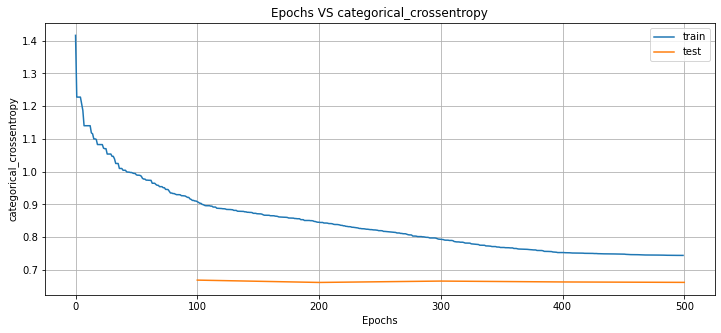

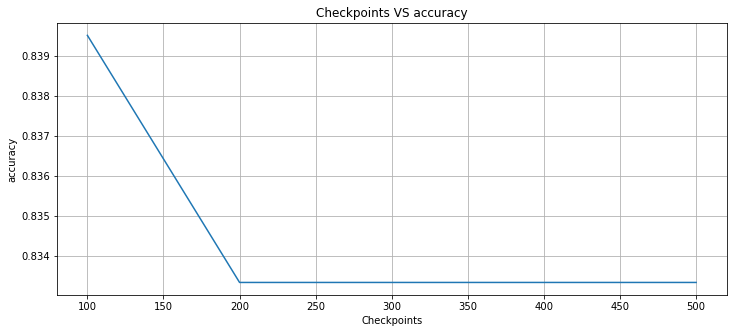

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8395061728395061, 'mean_square_error': 2.863246154741147, 'categorical_crossentropy': 0.6688502982810691, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.903076504831182, 'categorical_crossentropy': 0.661707913434064, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.8200652302016938, 'categorical_crossentropy': 0.665899983158818, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 4.9261156e-02]
 [-1.1759418e-02]
 [ 8.0246903e-04]
 [ 8.8639677e-01]
 [ 9.9129297e-02]]
 bias: [-1.220725]

Neuron 1: weights:
[[-0.0585105 ]
 [-0.71376514]
 [-0.00500743]
 [ 0.00496466]
 [-0.04332789]]
 bias: [0.05046168]

Neuron 2: weights:
[[-0.00251079]
 [-0.05161662]
 [-0.00266638]
 [ 0.00550093]
 [-0.02250893]]
 bias: [-0.02127303]

Neuron 3: weights:
[[ 0.0009793 ]
 [ 0.01491605]
 [-0.0173857 ]
 [-0.01166774]
 [-0.03744081]]
 bias: [0.00581739]

$
Layer 2
Neuron 0: weights:
[[-1.8456576 ]
 [ 2.280872  ]
 [ 0.08114816]
 [-0.00994099]]
 bias: [0.5543377]

Neuron 1: weights:
[[-0.00376864]
 [ 0.00442126]
 [-0.00052215]
 [-0.01920638]]
 bias: [-0.03707391]

Neuron 2: weights:
[[ 1.2562759e+00]
 [-6.5050475e-02]
 [ 4.5999413e-04]
 [-2.6417013e-02]]
 bias: [-0.7924614]

$

